In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap
from sklearn.model_selection import ShuffleSplit

C:\Users\kevink\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
#Reading File
accidents = pd.read_csv('C:/Users/kevink/Documents/Python/accidents/clean_accident_10.csv',index_col=False)
accidents.columns

Index(['Police_Force', 'Accident_Severity', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Day_of_Week', 'Time',
       'Local_Authority_(District)', '1st_Road_Class', '1st_Road_Number',
       'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
       '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_Band_of_Driver',
   

## Removing Incorrect Values - Additional Cleanup

In [4]:
# Converting continous variables as Integers
accidents = accidents.astype(str)
accidents[['Number_of_Vehicles','Number_of_Casualties','Engine_Capacity_(CC)','Age_of_Vehicle','Accident_Severity']] = accidents[['Number_of_Vehicles','Number_of_Casualties','Engine_Capacity_(CC)','Age_of_Vehicle','Accident_Severity']].astype(int)

#Removing unknown records from Road Type and Sex of Driver columns
accidents = accidents[(accidents['Road_Type'] != '9')]
accidents = accidents[(accidents['Sex_of_Driver'] != '3')]

#Engine Capacity over 20000 is an outlier and not possible
accidents = accidents[accidents['Engine_Capacity_(CC)'] < 20000]

#Encoding Severe/fatal accidents as Fatal 
accidents['Accident_Severity'] =accidents['Accident_Severity'].replace(2,1).replace(3,0)

print(accidents['Accident_Severity'].value_counts(),'\n')





0    827625
1    110518
Name: Accident_Severity, dtype: int64 



## Renaming Categories

In [5]:
cleanup_nums = {'1st_Road_Class': {"1":"Motorway","2":"A(M)","3":"A","4":"B","5":"C"},
                 'Road_Type': {"1":"Roundabout","2":"One way street","3":"Dual Carriageway","6":"Single Carriageway","7":"Slip road","9":"Unknown","12":"One way street/slip road"},
                 'Junction_Detail':{"0":"Not at junction","1":"Roundabout","2":"Mini-Roundabout","3":"T or staggered junction","5":"Slip road","6":"Crossroads","7":"More than 4 arms","8":"Private drive or entrance","9":"Other junction"},
                'Junction_Control':{"0":"Metres","1":"Authorised person","2":"Auto traffic signal","3":"Stop sign","4":"Uncontroled"},
                'Pedestrian_Crossing-Physical_Facilities':{"0":"No physical crossing facilities","1":"Zebra","4":"Pelican, puffin, toucan or similar non-junction pedestrian light crossing","5":"Pedestrian phase at traffic signal junction","7":"Footbridge","8":"Central refuge"},
                'Urban_or_Rural_Area':{"1": "Urban", "2": "Rural"},
                
                'Vehicle_Type':{"0":"Pedal cycle", "2": "Motorcycle 50cc and under","3":"Motorcycle 125cc and under","4":"Motorcycle over 125cc and up to 500cc","5":"Motorcycle over 500cc","8":"Taxi/Private hire car",
                                "9":"Car","10":"Minibus (8 - 16 passenger seats)","11":"Bus or coach","16":"Horse rider","17":"Agricultural vehicle","18":"Tram occupant","19":"Van / Goods vehicle ","20":"Goods vehicle (over 3.5t. and under 7.5t.)","21":"Goods vehicle (7.5 tonnes mgw and over)",
                               "22":"Mobility scooter","23":"Electric motorcycle","90":"Other vehicle","97":"Motorcycle - unknown cc","98":"Goods vehicle (unknown weight)"},
                
                'Vehicle_Manoeuvre':{"1": "Reversing", "2": "Parked","3":"Waiting to go","4":"Slowing/stopping","5":"Moving off","6":"U-turn","7":"Turning left","8":"Waiting to turning left","9":"Turning right","10":"Waiting to turning right","11":"Chaning lane to left","12":"Chaning lane to right",
                                    "13": "Overtaking moving vehicle-offside", "14": "Overtaking static vehicle-offside","15":"Overtaking-nearside","16":"Going ahead left-hand bend","17":"Going ahead right-hand bend","18":"Going ahead other"},
                'Junction_Location':{"0":"Near junction","1":"Approaching junction","2":"Clearing junction or wating/parking at junction","3":"Leaving roundabout","4":"Entering roundabout","5":"Leaving main road","6":"Entering main road","7":"Entering from slip road","8":"Mid junction"},
                'Skidding_and_Overturning':{"0":"None","1":"Skidded","2":"Skidded and Overturned","3":"Jackknifed","4":"Jackknifed and overturned","5":"Overturned"},
                'Hit_Object_off_Carriageway':{"0":"Near junction","1":"Previous accident","2":"Road works","4":"Parked works","5":"Bridge(roof)","6":"Bridge(side)","7":"Bollard or refuge","8":"Open door of vehicle","9":"Central island of roundabout","10":"Kerb","11":"Other object"},
                 '1st_Point_of_Impact':{"0": 'Not impact', "1": 'Front',"2":'Back',"3":'Offside',"4":'Nearside'},
                 'Journey_Purpose_of_Driver':{"1": 'Journey as part of work', "2": 'Commuting to/from work',"3":'Taking pupil to/from school',"4":"Pupil riding to/from school","5":"Other","6":"Unknown","15":"Others"}, 
                 'Sex_of_Driver':{"1": 'Male', "2": 'Female'},
                
                'Age_Band_of_Driver':{"1": '0-5', "2": '6-10',"3":'11-15',"4":'16-20',"5":'21-25',"6":'26-35', "7": '36-45',"8":'46-55',"9":'56-65',"10":"66-75","11":"over 75"},
                'Driver_IMD_Decile':{"1": 'Most deprived 10%', "2": 'More deprived 10-20%',"3":'More deprived 20-30%',"4":'More deprived 30-40%',"5":'More deprived 40-50%',"6":'Less deprived 50-40%',"7": 'Less deprived 40-30%',"8":'Less deprived 30-20%',"9":'Less deprived 20-10%',"10":"Less deprived 10%"},
                'Time_Cat':{"0": 'Weekday rushhour', "1": 'Weekend day',"2":'Weekend other',"3":'Weekday other'},
                "Day_of_Week": {"1": "Sun", "2": "Mon", "3": "Tue", "4": "Wed","5": "Thr", "6": "Fri", "7":"Sat" },
                "Accident_Severity":{1:"fatal" , 0:"Non Fatal"},
                
                'Light_Conditions': {"1": 'Daylight',"4": 'Darkness- lights lit', "5":'Darkness- lights unlit',"6":'Darkness-no lighting',"7":'Darkness-lighting unknown'},
                'Weather_Conditions': {"1":'Fine no high winds','2':"Raning no high winds",'3':"Snowing no high winds",'4':"Fine-high winds",'5':"Raining-high winds",'6':"Snowing-high winds","7":"Fog or mist","8":"Others","9":"Unknown"},
                'Road_Surface_Conditions': {"1":"Dry","2":"Wet or damp","3":"Snow","4":"Frost or ice","5":"Flood","6":"Oil or diesel"},
                'Special_Conditions_at_Site':{'0':"None","1":"Auto traffic signal-out","2":"Auto signal part defective","3":"Road sign or making defective or obscure","4":"Roadworks","5":"Road surfae defective","6":"Oil or diesel","7":"Mud"}}

accidents_1 = accidents.replace(cleanup_nums) 


## Target(Accident severity)

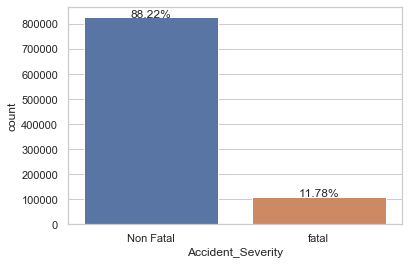

In [6]:
sns.set(style="whitegrid")

roadplot = sns.countplot(x='Accident_Severity',data=accidents_1)

for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 4, 
      '{:1.2f}'.format((height/len(accidents_1["Sex_of_Driver"]))*100)+'%',  
      ha="center") 
plt.show()

## The Day of week & Time

In [16]:
accidents['Hour']= accidents['Time'].str.extract(r'(\d+)\.\.*',expand=True)

accidents['Day_of_Week'] = accidents['Day_of_Week'].astype(str)
cleanup_nums = {"Day_of_Week": {"1": "Sun", "2": "Mon", "3": "Tue", "4": "Wed",
                                 "5": "Thr", "6": "Fri", "7":"Sat" }}
accidents = accidents.replace(cleanup_nums)

dayHour = accidents.groupby(by=['Day_of_Week','Hour']).count()['Number_of_Vehicles'].unstack()
dayHour

Hour,0,1,10,11,12,13,14,15,16,17,...,21,22,23,3,4,5,6,7,8,9
Day_of_Week,,,,,,,,,,,,,,,,,,,,,
Fri,1194,671,6666,7711,9157,9672,9748,12968,13552,14386,...,4833,4253,3470,469,341,892,2398,6471,11962,7892
Mon,937,585,6184,6763,7807,8114,8027,10365,11500,13344,...,3644,2734,1584,256,262,780,2119,6683,12275,7618
Sat,2463,1878,7045,8964,10486,9836,9434,8467,8799,9174,...,3935,3720,3234,1114,743,692,1183,2037,3382,5055
Sun,2677,2085,5210,6569,8268,8358,7816,7459,7399,6694,...,3376,2531,1781,1370,845,694,836,1239,1765,3256
Thr,1014,527,6216,6898,7858,8290,8262,10867,12132,14511,...,4072,3357,2097,308,268,804,2469,7298,13393,8177
Tue,824,422,6387,6862,7823,8056,8072,10816,12496,14876,...,3756,3112,1732,285,242,739,2530,7483,13886,8499
Wed,815,452,6334,6987,8033,8421,8342,10814,12056,15003,...,3864,3077,2060,248,243,795,2562,7589,13692,8292


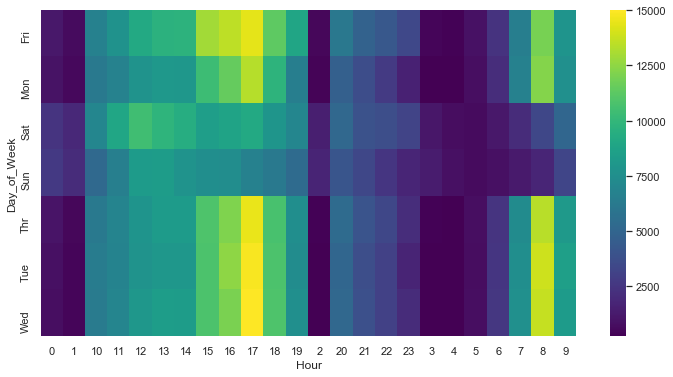

In [17]:
plt.figure(figsize=(12,6))
sns.heatmap(dayHour,cmap='viridis')

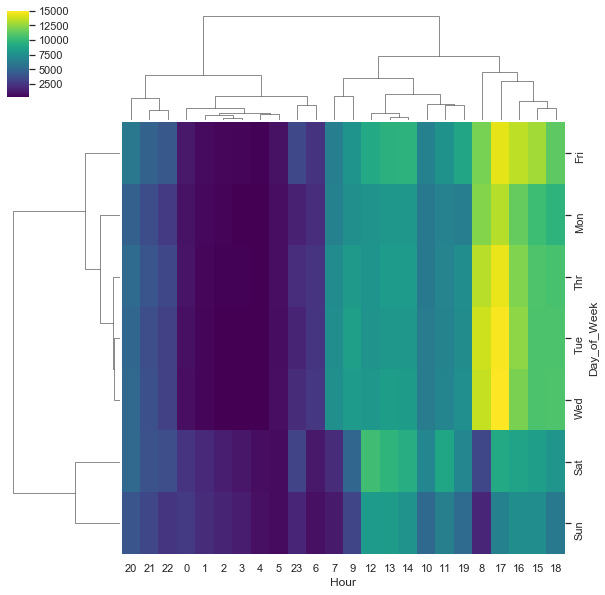

In [18]:
sns.clustermap(dayHour,cmap='viridis')

In [19]:
grouped = accidents[['Day_of_Week','Accident_Severity','Number_of_Vehicles']].groupby(['Day_of_Week','Accident_Severity']).count()
                                                                                                                                        
grouped

Number_of_Vehicles
Day_of_Week Accident_Severity                    
Fri         0                              137765
            1                               17912
Mon         0                              117967
            1                               14974
Sat         0                              107888
            1                               15391
Sun         0                               84301
            1                               13293
Thr         0                              126211
            1                               16472
Tue         0                              126126
            1                               16244
Wed         0                              127367
            1                               16232

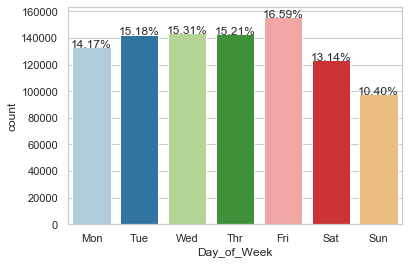

In [20]:

roadplot = sns.countplot(x='Day_of_Week',data=accidents,order=['Mon','Tue','Wed','Thr','Fri','Sat','Sun'],palette ="Paired")

for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 4, 
      '{:1.2f}'.format((height/len(accidents["Day_of_Week"]))*100)+'%',  
      ha="center") 
plt.show()

# Age

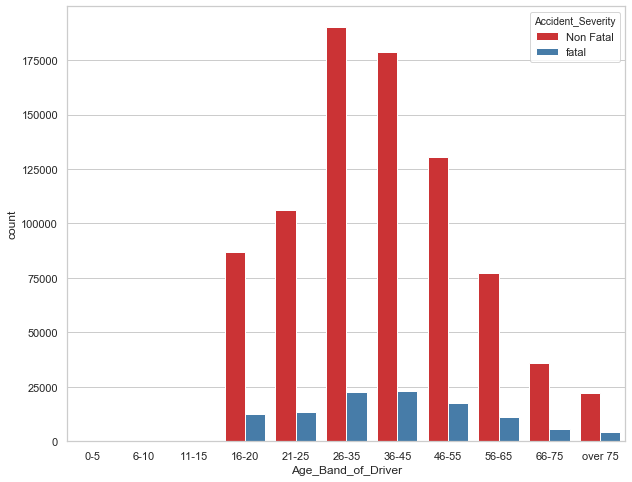

In [21]:

plt.figure(figsize=(10,8))
roadplot = sns.countplot(x='Age_Band_of_Driver',data=accidents_1,hue='Accident_Severity',
              order=['0-5','6-10','11-15','16-20','21-25','26-35','36-45','46-55','56-65','66-75','over 75'],palette='Set1')


posx and posy should be finite values
posx and posy should be finite values


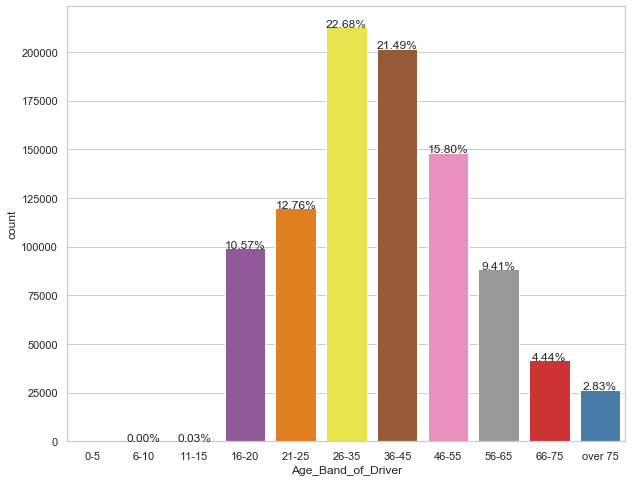

In [23]:

plt.figure(figsize=(10,8))
roadplot = sns.countplot(x='Age_Band_of_Driver',data=accidents_1,
              order=['0-5','6-10','11-15','16-20','21-25','26-35','36-45','46-55','56-65','66-75','over 75'],palette='Set1')

for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 4, 
      '{:1.2f}'.format((height/len(accidents_1["Age_Band_of_Driver"]))*100)+'%',  
      ha="center") 
plt.show()


## Gender

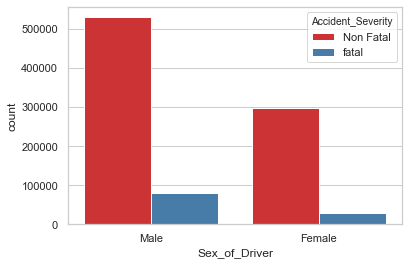

In [24]:
sns.countplot(x="Sex_of_Driver",data=accidents_1,hue='Accident_Severity',palette='Set1')

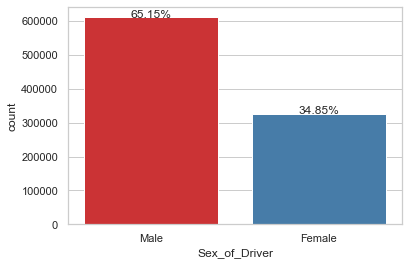

In [25]:

roadplot = sns.countplot(x="Sex_of_Driver",data=accidents_1,palette='Set1')

for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 4, 
      '{:1.2f}'.format((height/len(accidents_1["Sex_of_Driver"]))*100)+'%',  
      ha="center") 
plt.show()

## Urban or Rural 

In [26]:
grouped1 = accidents[['Urban_or_Rural_Area','Accident_Severity','Number_of_Vehicles']].groupby(['Urban_or_Rural_Area','Accident_Severity']).count()
grouped1

Number_of_Vehicles
Urban_or_Rural_Area Accident_Severity                    
1                   0                              612463
                    1                               73665
2                   0                              215162
                    1                               36853

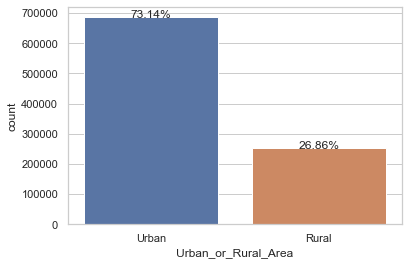

In [27]:
roadplot = sns.countplot(x="Urban_or_Rural_Area",data=accidents_1)

for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 4, 
      '{:1.2f}'.format((height/len(accidents_1["Urban_or_Rural_Area"]))*100)+'%',  
      ha="center") 
plt.show()

## Condition 

Weather condition

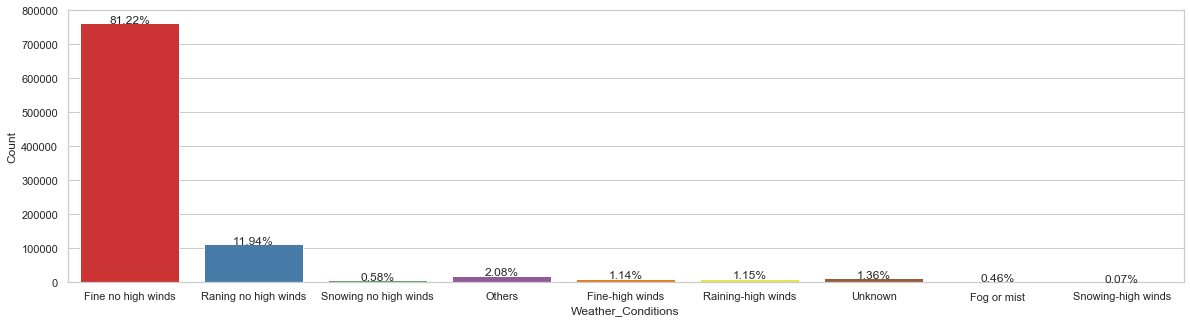

In [13]:
plt.figure(figsize=(20,5))
roadplot = sns.countplot(x="Weather_Conditions",data=accidents_1,palette='Set1')
roadplot.set(xlabel="Weather_Conditions", ylabel='Count')
for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 4, 
      '{:1.2f}'.format((height/len(accidents_1["Weather_Conditions"]))*100)+'%',  
      ha="center") 
plt.show()

Light condition

In [8]:

grouped = accidents.groupby(['Accident_Severity','Light_Conditions']).size().reset_index().pivot(columns='Light_Conditions', index='Accident_Severity', values=0)
grouped

Light_Conditions,1,4,5,6,7
Accident_Severity,,,,,
0,626742,174908,3072,15392,7511
1,78662,26379,461,4109,907


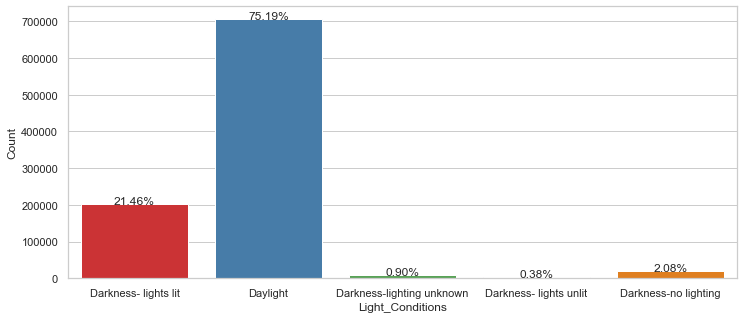

In [10]:

plt.figure(figsize=(12,5))
roadplot = sns.countplot(x='Light_Conditions',data=accidents_1,palette='Set1')
roadplot.set(xlabel='Light_Conditions', ylabel='Count')
for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 4, 
      '{:1.2f}'.format((height/len(accidents_1['Light_Conditions']))*100)+'%', ha="center") 
plt.show()

Surface condition

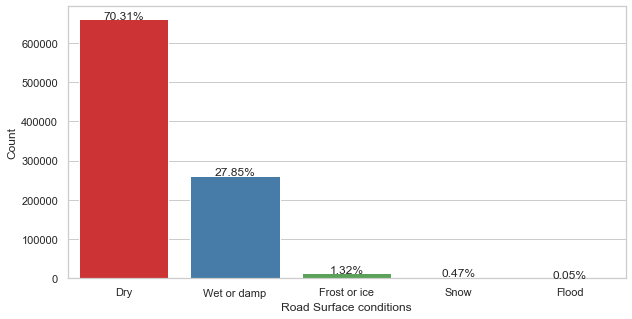

In [14]:
plt.figure(figsize=(10,5))
roadplot = sns.countplot(x='Road_Surface_Conditions',data=accidents_1,palette='Set1')
roadplot.set(xlabel='Road Surface conditions', ylabel='Count')
for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(accidents_1['Road_Surface_Conditions']))*100)+'%',  
      ha="center") 
plt.show()

## Vehicle 

Point_of_Impact

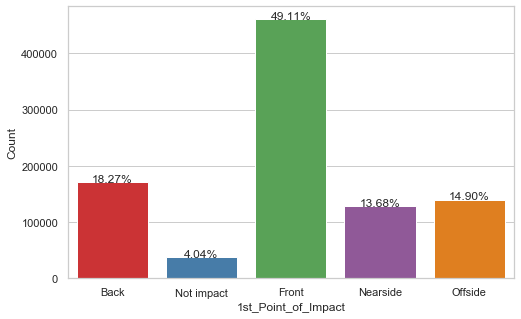

In [29]:
plt.figure(figsize=(8,5))
roadplot = sns.countplot(x='1st_Point_of_Impact',data=accidents_1,palette='Set1')
roadplot.set(xlabel='1st_Point_of_Impact', ylabel='Count')

for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(accidents_1['1st_Point_of_Impact']))*100)+'%',  
      ha="center") 
plt.show()

Skidded or overturned 

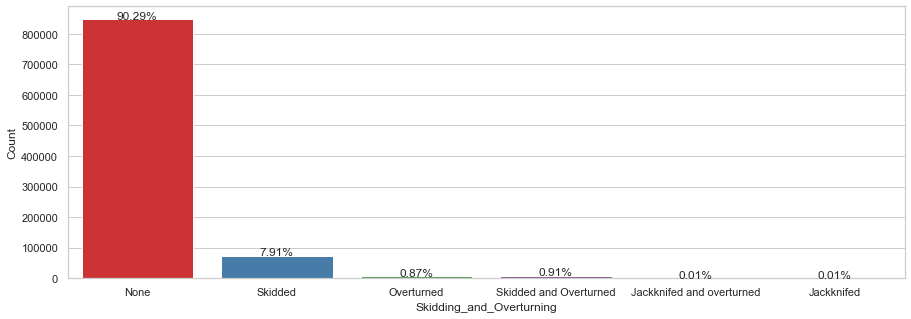

In [30]:
plt.figure(figsize=(15,5))
roadplot = sns.countplot(x='Skidding_and_Overturning',data=accidents_1,palette='Set1')
roadplot.set(xlabel='Skidding_and_Overturning', ylabel='Count')
for p in roadplot.patches: 
    height = p.get_height() 
    roadplot.text(p.get_x()+p.get_width()/2., 
      height + 3, 
      '{:1.2f}'.format((height/len(accidents_1['1st_Point_of_Impact']))*100)+'%',  
      ha="center") 
plt.show()


## Road type

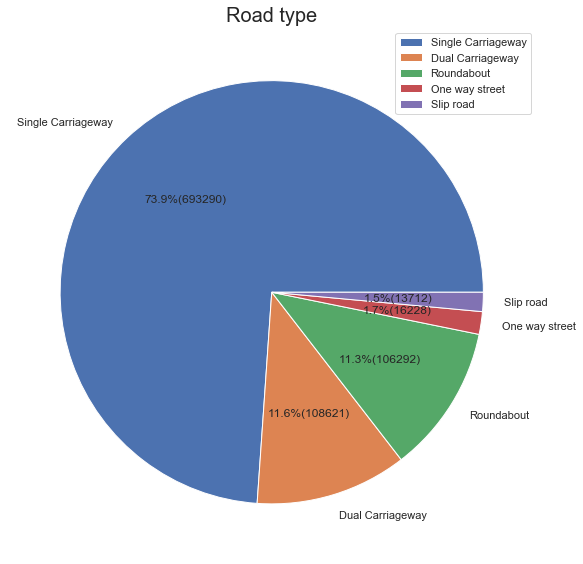

In [31]:
values = list(accidents_1['Road_Type'].value_counts())
labels = ["Single Carriageway","Dual Carriageway","Roundabout","One way street","Slip road"] 

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%({v:d})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.pie(values, labels=labels, autopct=make_autopct(values))

ax1.legend(labels, loc="best")
plt.title('Road type',fontsize=20)
plt.tight_layout()
plt.show()

## Junction Location

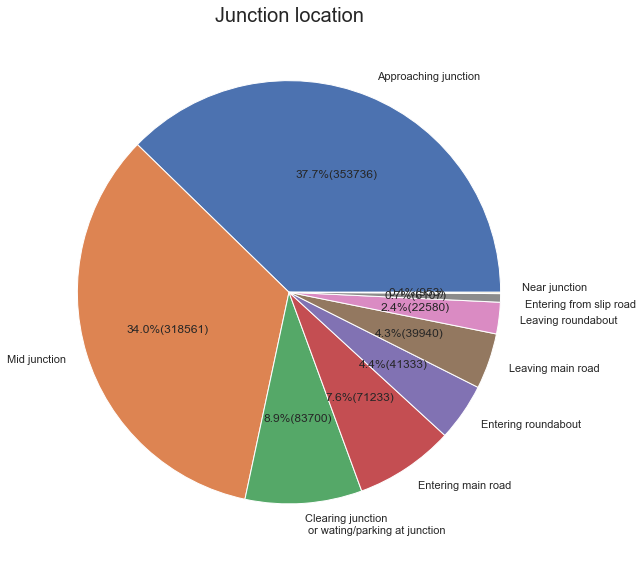

In [32]:
values = list(accidents_1['Junction_Location'].value_counts())
labels = ['Approaching junction', 'Mid junction',
       'Clearing junction \n or wating/parking at junction', 'Entering main road',
       'Entering roundabout', 'Leaving main road', 'Leaving roundabout',
       '\n Entering from slip road', 'Near junction \n']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%({v:d})'.format(p=pct,v=val)
    return my_autopct

fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.pie(values, labels=labels, autopct=make_autopct(values))

plt.title('Junction location',fontsize=20)
plt.tight_layout()

plt.show()

# ML 

Pre Processing

In [29]:
accidents = pd.read_csv('C:/Users/kevink/Documents/Python/accidents/clean_accident_10.csv',index_col=False)
len(accidents.columns)

44

In [30]:
# Dropping Administrative, Location based ,Redundant and Reference columns

accidents = accidents.drop('Local_Authority_(District)',axis = 1)
accidents = accidents.drop('Day_of_Week',axis = 1)
accidents = accidents.drop('Time',axis = 1)
accidents = accidents.drop('1st_Road_Number',axis = 1)
accidents = accidents.drop('2nd_Road_Number',axis = 1)
accidents = accidents.drop('Vehicle_Reference',axis = 1)
accidents = accidents.drop('Police_Force',axis = 1)

In [76]:
#Combining Severe and Fatal categories from non-fatal categories - fatal = 1 and non fatal = 0

accidents_1 = accidents

accidents_1['Accident_Severity'] =accidents_1['Accident_Severity'].replace(2,1).replace(3,0)
print(accidents_1['Accident_Severity'].value_counts())

0    831420
1    110896
Name: Accident_Severity, dtype: int64


In [33]:
#Removing outliers and incorrect values based on industry knowledge (example -  engine cc of 20k)

accidents_1 = accidents_1[(accidents_1['Road_Type'] != 9)]
accidents_1 = accidents_1[(accidents_1['Sex_of_Driver'] != 3)]
accidents_1 = accidents_1[accidents_1['Engine_Capacity_(CC)'] < 20000]



In [87]:
from sklearn.utils import shuffle
#Manual sampling for better predictions.Results were better with manual sampling during test run

accidents_1 = shuffle(accidents_1)
temp1 = accidents_1[accidents_1['Accident_Severity'] == 1]
temp2 = accidents_1[accidents_1['Accident_Severity'] == 0]
temp2 = accidents_1.iloc[1:250000,:]

#Final Sample Dataframe
temp_en = pd.concat([temp1,temp2],axis = 0)

#Encoding for Regression and Naive Bayes
temp_enc = temp_en.astype(str)
temp_enc[['Number_of_Vehicles','Number_of_Casualties','Engine_Capacity_(CC)','Age_of_Vehicle','Accident_Severity']] = temp_enc[['Number_of_Vehicles','Number_of_Casualties','Engine_Capacity_(CC)','Age_of_Vehicle','Accident_Severity']].astype(int)

temp = pd.get_dummies(temp_enc, columns = ['1st_Road_Class','Road_Type', '2nd_Road_Class','Junction_Detail', 
        'Junction_Control','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards','Speed_limit',
       'Urban_or_Rural_Area', 'Vehicle_Type',
       'Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_Band_of_Driver',
       'Propulsion_Code','Driver_IMD_Decile','Driver_Home_Area_Type' ,'Time_Cat','Towing_and_Articulation'],drop_first = True)

#Same dataframe without encoding
temp_no_enc = temp_en
print(len(temp_no_enc.columns),len(temp.columns))

37 207


Splitting Test and Training

In [78]:
#Ignoring minor differences in the change of record in test and training set for Decison trees and Regression models

#For Regression and Naive Bayes
len_df = len(temp.columns)-1
X = temp.iloc[:, 1:len_df]
y = temp.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state = 3)

#For Decision Tree and Random Forest

X_no = temp_no_enc.iloc[:, 1:36]
y_no = temp_no_enc.iloc[:,0]
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no,y_no, test_size=0.20,random_state = 3)


## Logistic Regression

In [88]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clf = LogisticRegression(class_weight = 'balanced')
    lr_train = clf.fit(X_train,y_train)

lr_pred = lr_train.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,lr_pred)
auc = metrics.roc_auc_score(y_test, lr_pred)

print('Logistic Regression')
cm = confusion_matrix(y_test, lr_pred)
cr = classification_report(y_test,lr_pred)


print(cr)
print(cm)


Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.65      0.69     44077
           1       0.53      0.64      0.58     28102

    accuracy                           0.64     72179
   macro avg       0.63      0.64      0.63     72179
weighted avg       0.66      0.64      0.65     72179

[[28445 15632]
 [10203 17899]]


## Decision Tree

In [91]:
    #Computing parameters through Grid Search
    
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    
    opt_tree = DecisionTreeClassifier()
    cv = ShuffleSplit(test_size=0.01, n_splits=1)
    param_DT = {"max_depth": range(1,10),
           "max_leaf_nodes": range(2,10),"criterion":['gini','entropy']}
    grid_tree = GridSearchCV(opt_tree,param_DT,cv = cv)
    grid_tree.fit(X_train_no,y_train_no)
    print(grid_tree.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 9}


In [92]:
#Training the Model

opt_tree = DecisionTreeClassifier(criterion = 'gini',max_depth = 5,max_leaf_nodes = 9,class_weight = 'balanced')
    
d_train = opt_tree.fit(X_train_no,y_train_no)
d_pred = d_train.predict(X_test_no)
    
print('Decision Tree')
print(classification_report(y_test_no,d_pred))
print(confusion_matrix(y_test_no, d_pred))

Decision Tree
              precision    recall  f1-score   support

           0       0.73      0.66      0.69     44077
           1       0.53      0.61      0.57     28102

    accuracy                           0.64     72179
   macro avg       0.63      0.63      0.63     72179
weighted avg       0.65      0.64      0.64     72179

[[28951 15126]
 [10929 17173]]


## Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

shuffle_rnd_clf = RandomForestClassifier(n_estimators=700, criterion = 'gini',max_depth = 5,max_leaf_nodes = 9,class_weight='balanced')
rf = shuffle_rnd_clf.fit(X_train_no, y_train_no)
shuffle_rnd_y_pred = shuffle_rnd_clf.predict(X_test_no)


classification_report = classification_report(y_test_no, shuffle_rnd_y_pred)

print('Random Forest')
print(classification_report)
print(confusion_matrix(y_test_no, shuffle_rnd_y_pred))

Random Forest
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     44077
           1       0.57      0.57      0.57     28102

    accuracy                           0.66     72179
   macro avg       0.65      0.65      0.65     72179
weighted avg       0.66      0.66      0.66     72179

[[31762 12315]
 [12067 16035]]


## Naive Bayes

In [94]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cnb = ComplementNB()
nb = cnb.fit(X_train,y_train)
nb_pred = nb.predict(X_test)
confusion_matrix = confusion_matrix(y_test, nb_pred)

print('Naive Bayes')
print(classification_report(y_test,nb_pred))
print(confusion_matrix)

Naive Bayes
              precision    recall  f1-score   support

           0       0.71      0.61      0.66     44077
           1       0.50      0.61      0.55     28102

    accuracy                           0.61     72179
   macro avg       0.60      0.61      0.60     72179
weighted avg       0.63      0.61      0.61     72179

[[26788 17289]
 [10904 17198]]


## ROC Curve and AUC Score

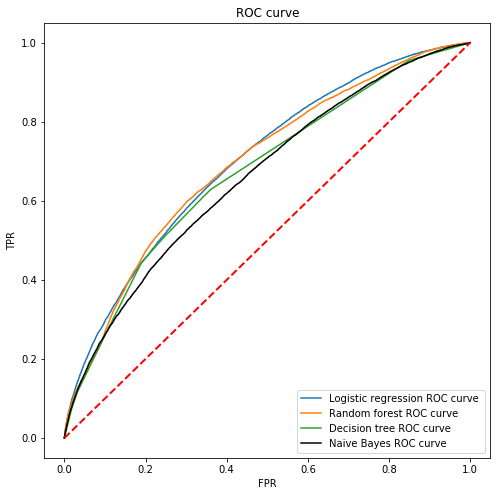

auc_lr  0.6990229689673559
auc_dt  0.6727006473281394
auc_rf  0.6938131010943451
auc_nb  0.6606840863776723


In [97]:
rf_probs = rf.predict_proba(X_test_no)[:, 1]
d_probs = d_train.predict_proba(X_test_no)[:, 1]
lr_probs = lr_train.predict_proba(X_test)[:, 1]
nb_probs = nb.predict_proba(X_test)[:, 1]

fpr3, tpr3, thresholds=metrics.roc_curve(y_test, lr_probs) #Logistic Regression
fpr4, tpr4, thresholds1=metrics.roc_curve(y_test_no, rf_probs) #Random Forest
fpr5, tpr5, thresholds2=metrics.roc_curve(y_test_no,d_probs)  #Decision Tree
fpr6, tpr6, threshold3= metrics.roc_curve(y_test,nb_probs) #Naive Bayes



#Computing AUC Scores
auc_lr = metrics.roc_auc_score(y_test, lr_probs) #Logistic Regression
auc_dt = metrics.roc_auc_score(y_test_no, d_probs) #Decision Tree
auc_rf = metrics.roc_auc_score(y_test_no, rf_probs) #Random Forest
auc_nb = metrics.roc_auc_score(y_test, nb_probs) #Naive Bayes

plt.figure(figsize=(8,8))
plt.plot(fpr3, tpr3, label="Logistic regression ROC curve ")
plt.plot(fpr4, tpr4, label="Random forest ROC curve" )
plt.plot(fpr5, tpr5, label="Decision tree ROC curve")
plt.plot(fpr6, tpr6, label="Naive Bayes ROC curve",color ='black')    




plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)


plt.show()

print('auc_lr ',auc_lr)
print('auc_dt ',auc_dt)
print('auc_rf ',auc_rf)
print('auc_nb ',auc_nb)



## Feature importance based on Random Forest

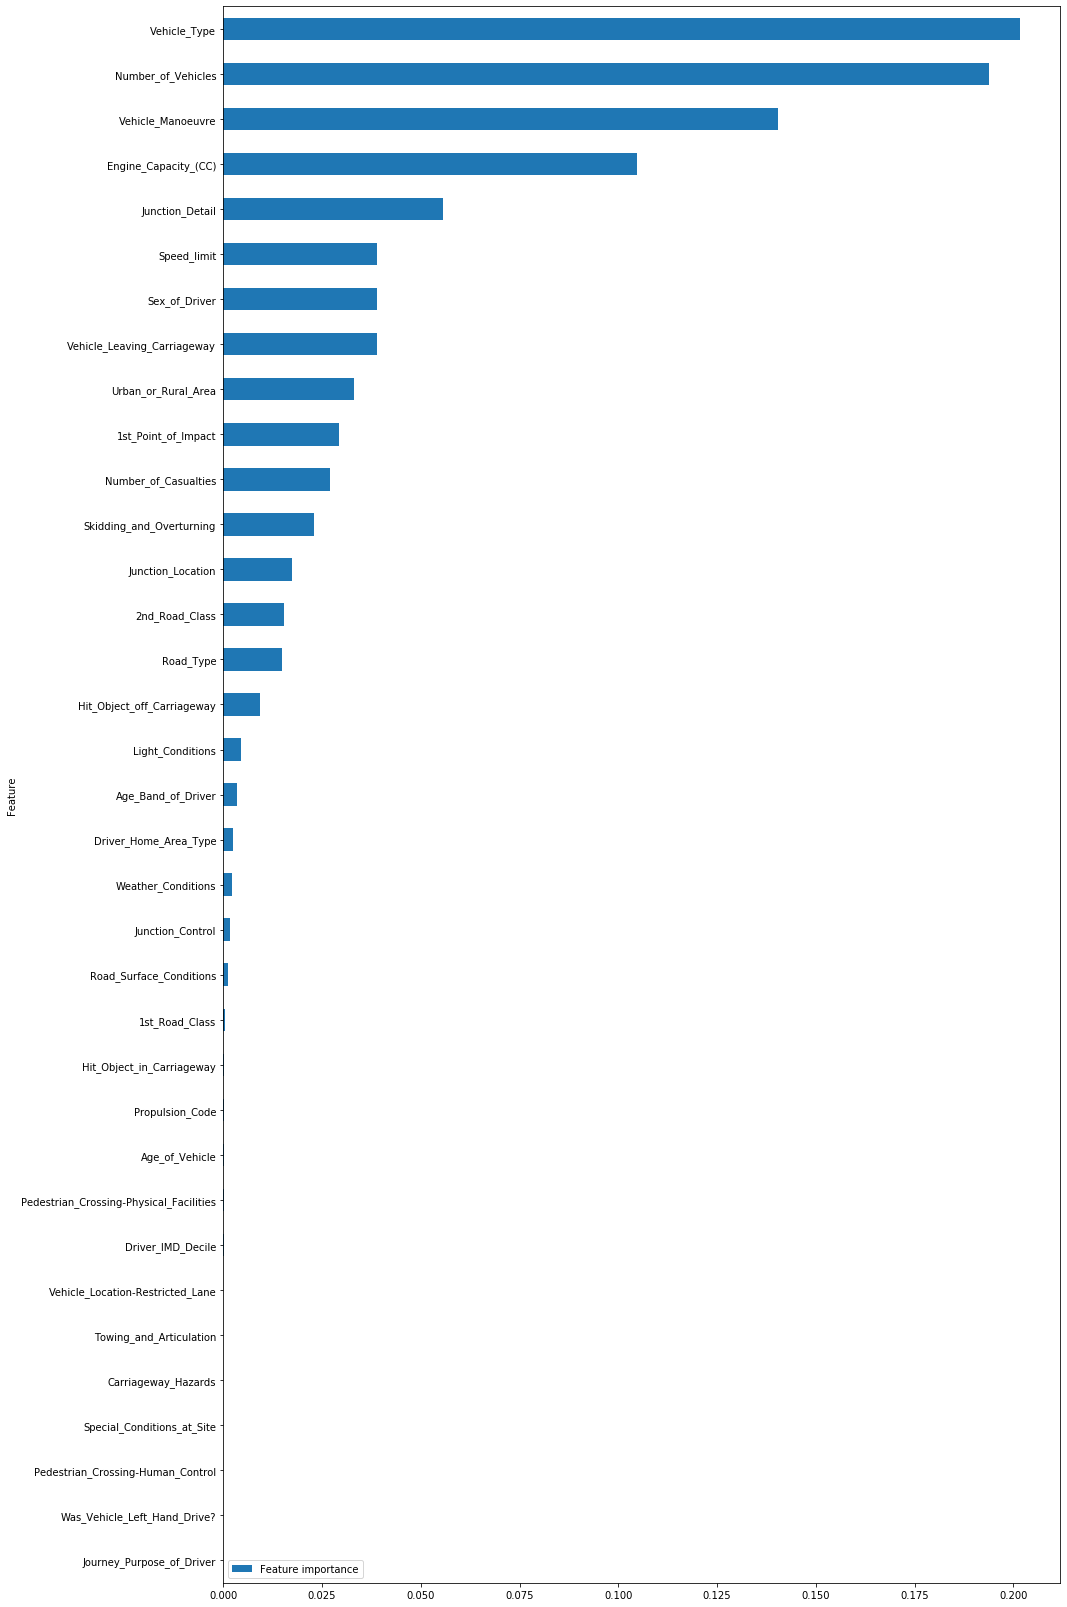

In [102]:
data = pd.DataFrame({
    'Feature': X_no.columns,
    'Feature importance': rf.feature_importances_
})

data = data.sort_values('Feature importance',ascending=True)

fig,ax = plt.subplots(figsize=(15,29))
data.plot(x='Feature',kind='barh',ax=ax)